# Text analysis of Machine Learning course syllabi

## Packages

In [70]:
import pandas as pd
import numpy as np
import os
from os import walk
import sklearn 

import regex # for tokenizing
import nltk # for stop words
nltk.download('stopwords')

from collections import Counter # for word counts

# visualization tools
from wordcloud import WordCloud
from matplotlib import pyplot as plt

from textacy import extract #Key Word in Context - pulls surrounding text for a keyword

import random

import re # for regex cleaning
import html
import textacy.preprocessing as tprep # normalizing

# topic modeling
from sklearn.feature_extraction.text import TfidfVectorizer
from spacy.lang.en.stop_words import STOP_WORDS as stopwords
from sklearn.decomposition import NMF
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from tqdm import tqdm

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\wat6sv\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Read in Data

In [71]:
cwd = os.getcwd() # Get current path
mypath = cwd+"\\txt_files" #path to dir that holds txt files
files = next(walk(mypath), (None, None, []))[2] #file names (with .txt)

In [72]:
# remove .txt from file names to get syllabus names

syll_names = [file[:-4] for file in files]
syll_names = [file for file in syll_names if file is not None]

In [73]:
corpus = pd.DataFrame()

# Read in text from each file - save to corpus df along with syllabus name
for file in files:
    path = mypath+"\\"+file
    with open(path, encoding='latin-1') as f:
        # print(chardet.detect(f.read())['encoding'])
        line = f.read()#.decode(chardet.detect(f.read())['encoding'])
        temp = pd.DataFrame({"name":syll_names[files.index(file)], "text":line}, index=[0])
        corpus = pd.concat([corpus, temp])
        f.close()


corpus = corpus.reset_index(drop=True)



In [74]:
# add length field to df
corpus['length'] = corpus['text'].str.len()

## Visualize data distributions

<Axes: title={'center': 'Length of Syllabi'}>

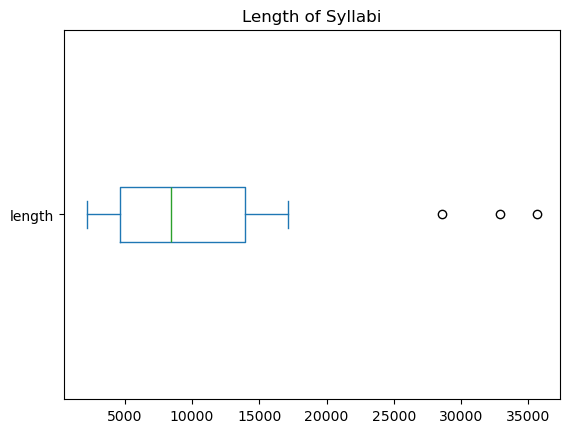

In [75]:
corpus['length'].plot(kind='box', vert=False, title="Length of Syllabi")

> Most syllabi are between 2500 - 18000 characters. There are 3 outliers that have >28000 characters.

<Axes: title={'center': 'Distribution of Length'}, ylabel='Frequency'>

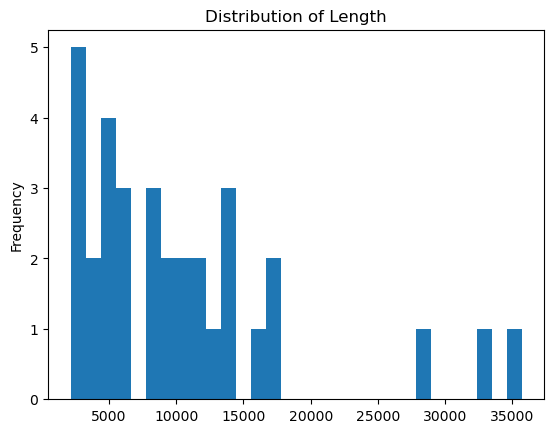

In [76]:
corpus['length'].plot(kind='hist', bins=30, title="Distribution of Length")

## Tokenize

In [77]:
def tokenize(text):
    '''
    Separate string into word-level tokens the contain at least 
    1 unicode letter surrounded by 0+ word characters [a-zA-Z0-9_] 
        - [\w]* matches 0+ word characters
        - \p{L} matches any unicode character
        - [\w]* at the end matches word characters, which accounts for trailing characters
    '''
    return regex.findall(r'[\w]*\p{L}[\w]*', text)

In [78]:
stopwords = set(nltk.corpus.stopwords.words('english')) #convert to set for fast lookup
stopwords |= {"â", "www"} # add stop words
# stopwords -= {} #remove stopwords

def remove_stop(tokens):
    return [t for t in tokens if t.lower() not in stopwords]

In [79]:
pipeline = [str.lower, tokenize, remove_stop]

def prepare(text, pipeline):
    tokens = str(text)
    for transform in pipeline:
        tokens = transform(tokens)
    return tokens 

In [80]:
corpus['tokens'] = corpus['text'].apply(prepare, pipeline=pipeline)

In [81]:
corpus['num_tokens'] = corpus['tokens'].map(len)

In [82]:
def count_words(df, column='tokens', preprocess=None, min_freq=2):

    # process tokens and update counter
    def update(doc):
        tokens = doc if preprocess is None else preprocess(doc)
        counter.update(tokens)

    # create counter and run through all data
    counter = Counter()

    if type(df) == pd.DataFrame:
        df[column].map(update)
    else:
        counter.update(df[column])

    # transform counter into a DataFrame
    freq_df = pd.DataFrame.from_dict(counter, orient='index', columns=['freq'])
    freq_df = freq_df.query('freq >= @min_freq')
    freq_df.index.name = 'token'

    return freq_df.sort_values('freq', ascending=False)

In [83]:
freq_df = count_words(corpus)

### Visualize Tokens

[Text(0.5, 0, 'Frequency'), Text(0, 0.5, 'Token'), Text(0.5, 1.0, 'Top Words')]

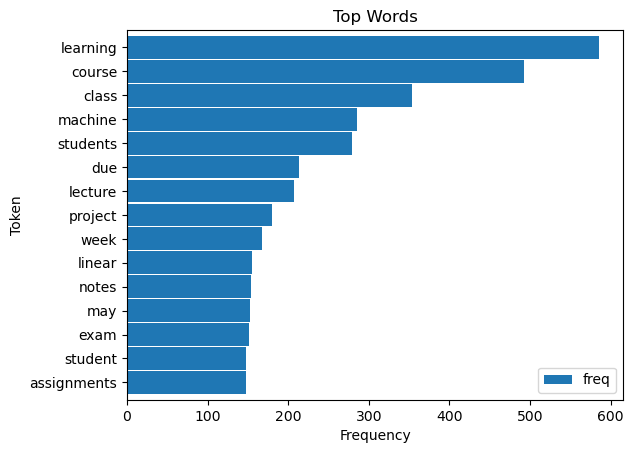

In [84]:
ax = freq_df.head(15).plot(kind='barh', width=0.95)
ax.invert_yaxis()
ax.set(xlabel='Frequency', ylabel='Token', title='Top Words')

In [85]:
def wordcloud(word_freq, save_plot = False, save_name = None, title=None, max_words=200, stopwords=None):

    wc = WordCloud(background_color="white", max_words=max_words,
                       width=960, height=540)

    # convert DataFrame into dict
    if type(word_freq) == pd.Series:
        counter = Counter(word_freq.fillna(0).to_dict())
    else:
        counter = word_freq

    # filter stop words in frequency counter
    if stopwords is not None:
        counter = {token:freq for (token, freq) in counter.items()
                              if token not in stopwords}
    wc.generate_from_frequencies(counter)
    plt.figure(figsize=(12,12))

    plt.title(title)

    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")

    if save_plot:
        plt.savefig(f'{save_name}.png')

        # 
        # plt.imshow(wc, interpolation='bilinear')
        # plt.axis("off")
        # # if you don't want to save the topic model, comment the next line
        # plt.savefig(f'{model_name}_topic{topic}.png')

### Word Clouds

#### All syllabi in Corpus

In [86]:
# wordcloud(freq_df['freq'], max_words = 100)

#### Individual Schools

In [87]:
for index, rows in corpus.iterrows():
    print(corpus.iloc[index,0])
    # wordcloud(count_words(corpus.iloc[index,:])['freq'], max_words = 100)

ASU_23F
BU_21F
CarnegieMellon_24Su
Cornell_24Sp
DU_18Sp
GTech_21Sp
GTech_Sp24
GWU_22Sp
Harvard_24Sp
NJIT24Sp
NJIT_24Sp
NYUParis_24F
OSU
Rice_Sp23
RIT_22F
RIT_24F
SJSU_F24
Stanford_23F
Tufts_23F
UArizona_24F
UArk_21F
UFlorida_22Sp
UMassAmherst_2020Sp
UMassAmherst_22Sp
UMich_F24
UNM_23F
UNM_F
UoM_24F
USC_19F
USC_22F
USC_23Sp
UTEP_24Sp
UW_24Sp


## TF-IDF

In [88]:
def compute_idf(df, column='tokens', preprocess=None, min_df=2):

    def update(doc):
        tokens = doc if preprocess is None else preprocess(doc)
        counter.update(set(tokens))

    # count tokens
    counter = Counter()
    df[column].map(update)

    # create DataFrame and compute idf
    idf_df = pd.DataFrame.from_dict(counter, orient='index', columns=['df'])
    idf_df = idf_df.query('df >= @min_df')
    idf_df['idf'] = np.log(len(df)/idf_df['df'])+0.1
    idf_df.index.name = 'token'
    return idf_df

In [89]:
idf_df = compute_idf(corpus)

C:\Users\wat6sv\AppData\Local\Temp\ipykernel_38344\4234653083.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  idf_df['idf'] = np.log(len(df)/idf_df['df'])+0.1


In [90]:
freq_df['tfidf'] = freq_df['freq'] * idf_df['idf']

In [91]:
freq_df.sort_values('tfidf', ascending=False)

,freq,tfidf
token,,
canvas,120,155.270696
sec,47,136.457938
refer,61,134.823005
tue,64,127.172458
thu,64,127.172458
...,...,...
weinberger,2,NaN
outcomesâ,2,NaN
examâ,2,NaN


## KWIC (Key word in Context)

In [92]:
def kwic(doc_series, keyword, window=35, print_samples=15):

    def add_kwic(text, doc_id):
        ## Create a list with doc ids and text
            contexts = extract.kwic.keyword_in_context(text, keyword, ignore_case=True, window_width=window)
            for context in contexts:
                kwic_list.append((doc_id, context))

    kwic_list = []
    for idx, text in enumerate(doc_series):
        add_kwic(text, idx)

    # Sort kwic_list by doc_id
    kwic_list.sort(key=lambda x: x[0])

    if print_samples is None or print_samples == 0:
        return kwic_list
    else:
        print(f"All contexts for '{keyword}':")
        for sample in kwic_list:
            doc_id, context = sample
            print(f"Document {doc_id}: " + re.sub(r'[\n\t]', ' ', context[0]) + '  ' + context[1] + '  ' + re.sub(r'[\n\t]', ' ', context[2]))

In [93]:
kwic(doc_series = corpus['text'], keyword = r'experiment', window = 50 )

All contexts for 'experiment':
Document 2: s Razor. Programming assignments include hands-on   experiment  s with various learning algorithms. This course is
Document 2: arning (supervised, unsupervised, etc...). Design   experiment  s to evaluate and compare different machine learni
Document 2: ld applications, building end-to-end systems, and   experiment  al design. The written assignments will focus on c
Document 5: r problem? What is new in your approach? Were the   experiment  s, results, and conclusion satisfactory? How did y
Document 12: d engineering. b An ability to design and conduct   experiment  s, as well as to analyze and interpret data. ** c 
Document 12: s 6 an ability to develop and conduct appropriate   experiment  ation, analyze and interpret data, and  use engine
Document 12: s 6 an ability to develop and conduct appropriate   experiment  ation, analyze and interpret data, and  use engine
Document 19: u are encouraged to use ChatGPT to debug code and   experiment  

In [94]:
kwic(doc_series = corpus['text'], keyword = r'experimental design', window = 50 )

All contexts for 'experimental design':
Document 2: ld applications, building end-to-end systems, and   experimental design  . The written assignments will focus on core conce
Document 21: n Trees, Random Forests,  and Linear Classifiers;   Experimental Design   and Hyperparameter Tuning Strategies â¨ (Assignm


In [95]:
kwic(doc_series = corpus['text'], keyword = r'scien', window = 50, print_samples=51)

All contexts for 'scien':
Document 1: uï¬alo and the School of Engineering and Applied   Scien  ces are committed to ensuring equal opportunity fo
Document 2: ) or 15-151 (Mathematical Foundations of Computer   Scien  ce), or comparable courses elsewhere, with a grade
Document 3:  committed to this, and subscribe to the Computer   Scien  ce Departmentâs Values of Inclusion. [Statement 
Document 4: Entities  Department of Mathematical and Computer   Scien  ces  Approval Process Name  10. UG New Course No S
Document 4: partment  Department of Mathematical and Computer   Scien  ces  Status:  Active-Visible  Prefix:  CS  Course 
Document 4:  CS  Course Number:  3120  Course Type:  Computer   Scien  ce  Course Title:  Machine Learning  Transcript Co
Document 4: ng is becoming a very important topic in computer   scien  ce and  we need a course that addresses this. It i
Document 4: the case that machine learning  is a part of data   scien  ce and the statistics professors have requested t

In [96]:
kwic(doc_series = corpus['text'], keyword = r'scientific method', window = 50 )

All contexts for 'scientific method':


In [97]:
kwic(doc_series = corpus['text'], keyword = r'scientific', window = 50 )

All contexts for 'scientific':
Document 6: ut I am assuming a familiarity with the basics of   scientific   programming (e.g., experience with C, MATLAB, or 


In [98]:
corpus

,name,text,length,tokens,num_tokens
0,ASU_23F,NO SPECIAL EXCEPTIONS ARE GRANTED TO THE POLIC...,28554,"[special, exceptions, granted, policies, sylla...",2683
1,BU_21F,CSE4/574: Introduction to Machine Learning\nFa...,5028,"[cse4, introduction, machine, learning, fall, ...",464
2,CarnegieMellon_24Su,CMU MLD Logo\nNarwhal Net\n10-301/601 \nSyllab...,32898,"[cmu, mld, logo, narwhal, net, syllabus, staff...",2940
3,Cornell_24Sp,cs4780logo\nCS 4/5780: Intro to Machine Learni...,11348,"[cs4780logo, cs, intro, machine, learning, ove...",1105
4,DU_18Sp,Metropolitan State University of Denver \nReg...,5817,"[metropolitan, state, university, denver, regu...",555
5,GTech_21Sp,CS4641\CS7641 A \nCourse overview\nSchedule\nC...,35685,"[cs4641, cs7641, course, overview, schedule, c...",3533
6,GTech_Sp24,ECE 6254: Statistical Machine Learning\nSpring...,13933,"[ece, statistical, machine, learning, spring, ...",1240
7,GWU_22Sp,GWU\nCS 4364/6364\nIntroduction to Machine Lea...,4674,"[gwu, cs, introduction, machine, learning, spr...",493
8,Harvard_24Sp,1\nW\neb\nsit\ne\nEd \nfor\num\nGoogle \nCalen...,3033,"[w, eb, sit, e, ed, um, google, calendar, reso...",405
9,NJIT24Sp,New Jersey Institute of Technology \nNew Jerse...,14294,"[new, jersey, institute, technology, new, jers...",1269


## n-grams

In [99]:
def ngrams(tokens, n=2, sep=' ', stopwords=set()):
    return [sep.join(ngram) for ngram in zip(*[tokens[i:] for i in range(n)])
            if len([t for t in ngram if t in stopwords])==0]


In [100]:
corpus['bigrams'] = corpus['text'].apply(prepare, pipeline=[str.lower, tokenize]) \
                          .apply(ngrams, n=2, stopwords=stopwords)

corpus['trigrams'] = corpus['text'].apply(prepare, pipeline=[str.lower, tokenize]) \
                          .apply(ngrams, n=3, stopwords=stopwords)

count_words(corpus, 'bigrams').head(20)

,freq
token,
machine learning,265
neural networks,80
linear algebra,55
deep learning,51
linear regression,51
office hours,48
academic integrity,46
supervised learning,42
support vector,40


C:\Users\wat6sv\AppData\Local\Temp\ipykernel_38344\4234653083.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  idf_df['idf'] = np.log(len(df)/idf_df['df'])+0.1


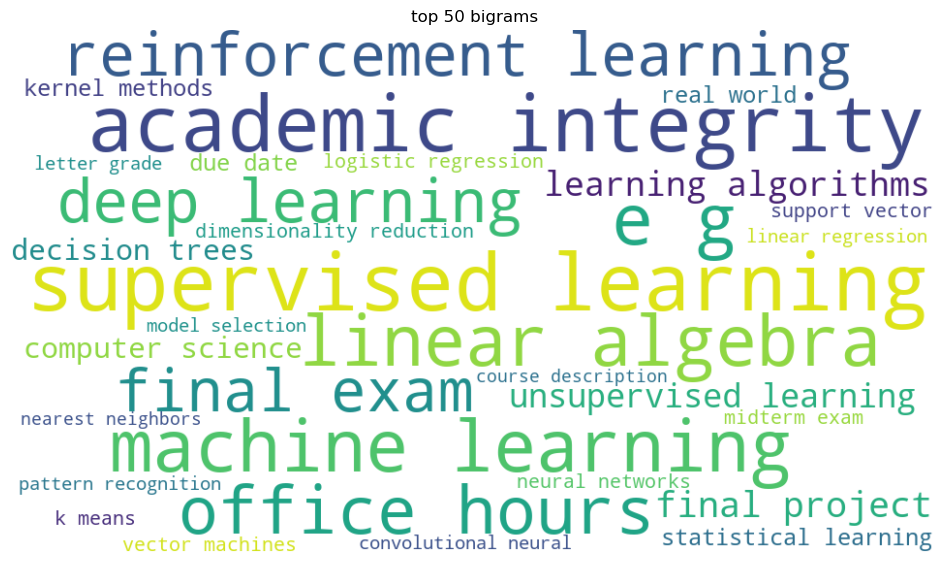

In [101]:
# concatenate existing IDF DataFrame with bigram IDFs
idf_df = pd.concat([idf_df, compute_idf(corpus, 'bigrams', min_df=10)])

freq_df = count_words(corpus, 'bigrams')
freq_df['tfidf'] = freq_df['freq'] * idf_df['idf']
wordcloud(freq_df['tfidf'], title='top 50 bigrams', max_words=50)

## Prep for Stats/ML Pipeline

### Identify & remove noise

In [102]:
RE_SUSPICIOUS = re.compile(r'[&#<>{}\[\]\\]')

def impurity(text, min_len=10):
    """returns the share of suspicious characters in a text"""
    if text == None or len(text) < min_len:
        return 0
    else:
        return len(RE_SUSPICIOUS.findall(text))/len(text)*100

print(impurity(corpus.loc[0,'text']), '%')

0.038523499334594105 %


In [103]:
corpus['impurity'] = corpus['text'].apply(impurity, min_len=10)

corpus[['text', 'impurity']].sort_values(by='impurity', ascending=False).head(5)

,text,impurity
32,CSE/STAT 416\nCSE/STAT 416\nHome / Calendar\n...,0.840263
18,Intro to Machine Learning\nTufts CS 135 | Fall...,0.732861
10,New Jersey Institute of Technology \nNew Jerse...,0.384300
31,\n \nCS 4361 \nIntroduction to Machine Learni...,0.336792
15,RIT Department of Computer Science\nSyllabus -...,0.325733


In [104]:
count_words(corpus, column='text', preprocess=lambda t: re.findall(r'#|:|\\', t))

,freq
token,
:,1508
#,25
\,5


In [105]:
def clean(text):
    # convert html escapes like &amp; to characters.
    text = html.unescape(text)
    # tags like <tab>
    text = re.sub(r'<[^<>]*>', ' ', text)
    # markdown URLs like [Some text](https://....)
    text = re.sub(r'\[([^\[\]]*)\]\([^\(\)]*\)', r'\1', text)
    # text or code in brackets like [0]
    text = re.sub(r'\[[^\[\]]*\]', ' ', text)
    # standalone sequences of specials, matches &# but not #cool
    text = re.sub(r'(?:^|\s)[&#<>{}\[\]+|\\:-]{1,}(?:\s|$)', ' ', text)
    # standalone sequences of hyphens like --- or ==
    text = re.sub(r'(?:^|\s)[\-=\+]{2,}(?:\s|$)', ' ', text)
    # sequences of white spaces
    text = re.sub(r'\s+', ' ', text)
    # escape chars
    text = re.sub(r'(\\n|\\t)', ' ', text)
    # numbers
    text = re.sub(r'([0-9]|[0-9][0-9]|[0-9][0-9][0-9]|[0-9][0-9][0-9][0-9])', ' ', text)
    return text.strip()

In [106]:
corpus['clean_text'] = corpus['text'].map(clean)

### Character Normalize

In [107]:
def normalize(text):
    text = tprep.normalize.hyphenated_words(text)
    text = tprep.normalize.quotation_marks(text)
    text = tprep.normalize.unicode(text)
    text = tprep.remove.accents(text)
    return text

In [108]:
corpus['clean_text'] = corpus['clean_text'].map(normalize)

### Data masking & further cleaning

In [109]:
count_words(corpus, column='clean_text', preprocess=tprep.resources.RE_URL.findall).head(3)

,freq
token,
https://people.cs.umass.edu/~pthomas/courses/COMPSCI_,2
http://viterbi-web.usc.edu/~adamchik/,2


In [110]:
corpus['clean_text'] = corpus['clean_text'].map(tprep.replace.urls) # replace all urls with '_url_'

In [111]:
clean_corpus = corpus[['name', 'clean_text']].copy()
clean_corpus['clean_text'] = clean_corpus['clean_text'].map(normalize)
clean_corpus['tokens'] = clean_corpus['clean_text'].apply(prepare, pipeline=pipeline)
clean_corpus.head()
clean_corpus.rename(columns={'clean_text':'text'}, inplace=True)

In [112]:
def remove_user_stop(tokens):
    return [t for t in tokens if t.lower() not in stop_words]

In [113]:
stop_words = {"page", "pages", "student", "students", "accommodation", "accommodations", "lo", "homework", "homeworks", "hw", "exam", "exams", "academic", "email", "policy", "policies", "campus", "support", "professor", "professors", "late", "discuss", "discussion", "discussion", "gradescope", "lab", "labs","professor", "professors", "_url_", "syllabus", "project", 'projects', "problem", "problems", "quiz", "quizzes", "course", "courses", "class", "classes", "week", "weeks", "schedule", "assignment", "assignments", "pm", "submit", "submissions", "question", "questions", "activities", "activity", "canvas", "please", "online", "lecture", "monday", "tuesday", "wednesday", "thursday", "friday", "saturday", "sunday", "university", "edu", "njit", "unm", "learning", "ri", "fe", "ap"}
clean_corpus['tokens'] = clean_corpus['tokens'].apply(remove_user_stop)

## Topic Modeling

In [114]:
stopwords = set(stopwords)
stopwords |= stop_words
stopwords = list(stopwords)

In [115]:
rand_state = 658268

In [116]:
def display_topics(model, features, no_top_words=5):
    '''
    Pull topics out of model and display top terms in topic
    '''
    for topic, word_vector in enumerate(model.components_):
        total = word_vector.sum()
        largest = word_vector.argsort()[::-1] # invert sort order
        topic = topic+1
        print("\nTopic %02d" % topic)
        for i in range(0, no_top_words):
            print("  %s (%2.2f)" % (features[largest[i]],
                  word_vector[largest[i]]*100.0/total))

### NMF
Nonnegative Matrix Factorization 

In [117]:
# Create matrix of TF-IDF scores
tfidf_text = TfidfVectorizer(stop_words=stopwords)
vectors_text = tfidf_text.fit_transform(clean_corpus['text'])
vectors_text.shape

(33, 4860)

In [118]:
# Fit NMF model
nmf_text_model = NMF(n_components=10, random_state=rand_state, max_iter=1000)
W_text_matrix = nmf_text_model.fit_transform(vectors_text)
H_text_matrix = nmf_text_model.components_

In [119]:
display_topics(nmf_text_model, tfidf_text.get_feature_names_out())



Topic 01
  may (0.40)
  must (0.36)
  code (0.36)
  solutions (0.33)
  written (0.33)

Topic 02
  slides (3.83)
  ch (2.95)
  pt (1.59)
  dl (1.58)
  thursda (1.27)

Topic 03
  kernel (1.58)
  kernels (1.20)
  gaussian (1.06)
  criterion (1.05)
  minimization (0.82)

Topic 04
  ml (0.74)
  thea (0.62)
  ch (0.60)
  prml (0.58)
  syllabi (0.58)

Topic 05
  engineering (1.24)
  machine (1.00)
  ability (0.92)
  supervised (0.76)
  eecs (0.64)

Topic 06
  sec (2.91)
  resources (2.53)
  sml (2.01)
  videos (1.78)
  extra (1.64)

Topic 07
  pml (1.78)
  html (1.01)
  usc (0.87)
  pdf (0.71)
  handwritten (0.65)

Topic 08
  chapter (1.32)
  machine (1.06)
  face (0.72)
  ai (0.67)
  generative (0.63)

Topic 09
  thurs (5.73)
  tues (5.22)
  due (3.87)
  topic (2.80)
  date (2.43)

Topic 10
  scribe (10.29)
  notes (4.81)
  solutions (3.47)
  ja (2.34)
  part (1.47)


In [120]:
# Find matrix weights
W_text_matrix.sum(axis=0)/W_text_matrix.sum()*100.0

array([13.82175042,  9.73500842,  9.36634867,  9.42899632, 12.74667765,
        8.09067631, 10.36287068, 12.27069389,  7.3270296 ,  6.84994803])

> The matrix weights indicate how big the topics are by copmuting how many documents can be mainly assigned to each topics. These weights show even distribution - indicating that 10 topics is a good fit on this model.

### LDA
latent dirichlet allocation

In [121]:
# Create token count matrix from cleaned text
count_vectorizer = CountVectorizer(stop_words=stopwords)#, min_df=5, max_df=0.7)
count_vectors = count_vectorizer.fit_transform(clean_corpus['text'])

# Fit multiple models to find the num topics with lowest perplexity score
perplex = {}
for n in range(1,11):    
    lda_model = LatentDirichletAllocation(n_components = n, random_state=rand_state)
    W_lda_matrix = lda_model.fit_transform(count_vectors)
    H_lda_matrix = lda_model.components_
    perplex[n]= lda_model.bound_

display(perplex)

{1: 2383.5712239843124,
 2: 2334.978054145056,
 3: 2290.0154860157486,
 4: 2283.0060186731084,
 5: 2248.701824472833,
 6: 2238.875167809722,
 7: 2196.8084982265927,
 8: 2154.5864796368355,
 9: 2271.621016373169,
 10: 2221.715791646855}

In [122]:
# Find the minimum score
(min(perplex.values()))

2154.5864796368355

> The minimum perplexity score is for the model with 8 topics.

In [123]:
lda_model = LatentDirichletAllocation(n_components = 8, random_state=rand_state)
W_lda_matrix = lda_model.fit_transform(count_vectors)
H_lda_matrix = lda_model.components_

In [124]:
display_topics(lda_model, tfidf_text.get_feature_names_out(), no_top_words=5)



Topic 01
  kernel (1.24)
  machine (0.92)
  gaussian (0.71)
  kernels (0.71)
  available (0.71)

Topic 02
  ml (1.07)
  machine (0.95)
  code (0.58)
  due (0.56)
  techexchange (0.55)

Topic 03
  machine (1.01)
  may (0.73)
  must (0.52)
  grade (0.50)
  inked (0.49)

Topic 04
  video (1.86)
  refer (1.64)
  qa (1.61)
  notes (1.41)
  data (1.19)

Topic 05
  due (1.53)
  linear (1.06)
  machine (1.04)
  regression (0.71)
  slides (0.63)

Topic 06
  machine (0.92)
  may (0.89)
  use (0.72)
  must (0.66)
  work (0.60)

Topic 07
  resources (4.77)
  videos (1.94)
  extra (1.73)
  advanced (1.31)
  due (1.26)

Topic 08
  machine (1.35)
  slides (1.30)
  sec (1.13)
  day (1.03)
  regression (1.03)


In [64]:
def wordcloud_topics(model, features, model_name, no_top_words=40):
    for topic, words in enumerate(model.components_):
        size = {}
        largest = words.argsort()[::-1] # invert sort order
        for i in range(0, no_top_words):
            size[features[largest[i]]] = abs(words[largest[i]])
        wc = WordCloud(background_color="white", max_words=100,
                       width=960, height=540)
        wc.generate_from_frequencies(size)
        plt.figure()
        plt.imshow(wc, interpolation='bilinear')
        plt.axis("off")
        # if you don't want to save the topic model, comment the next line
        plt.savefig(f'{model_name}_topic{topic}.png', bbox_inches='tight')

NMF Topics
LDA Topics


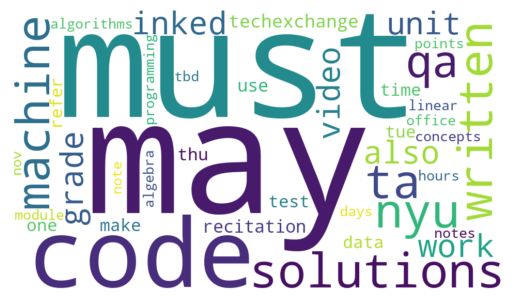

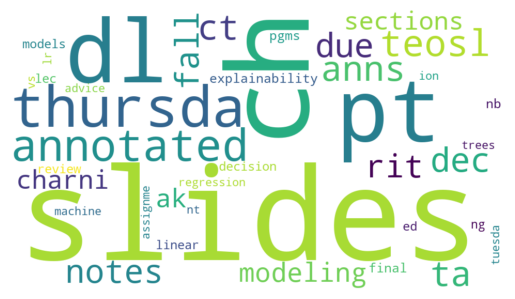

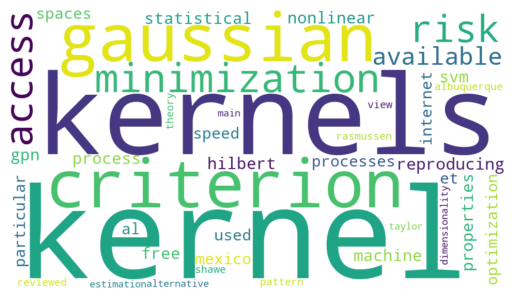

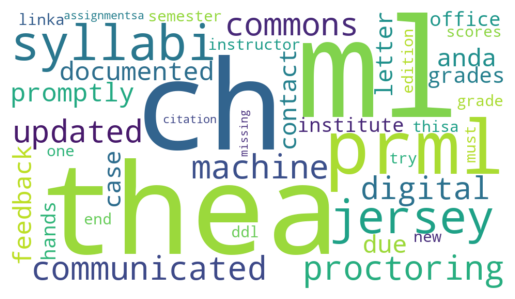

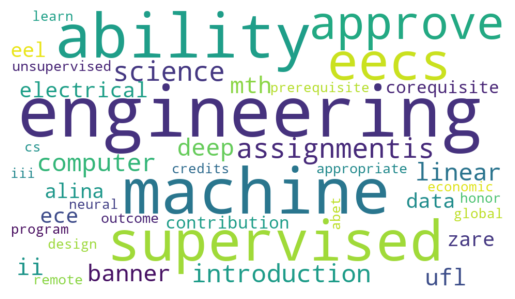

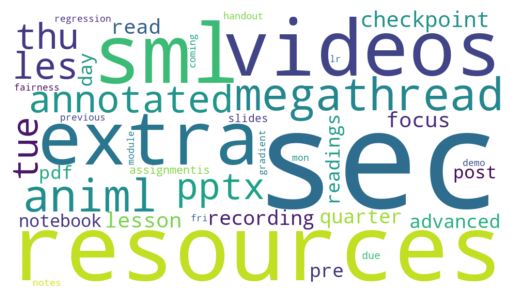

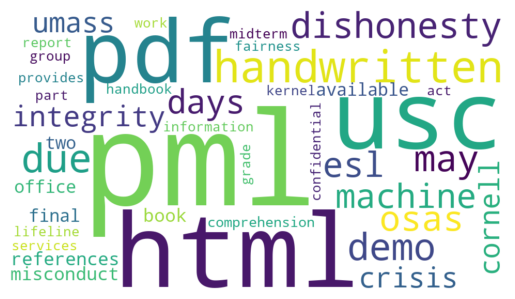

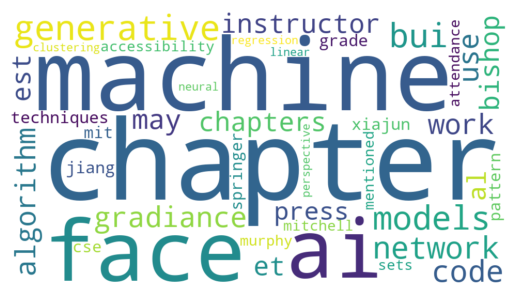

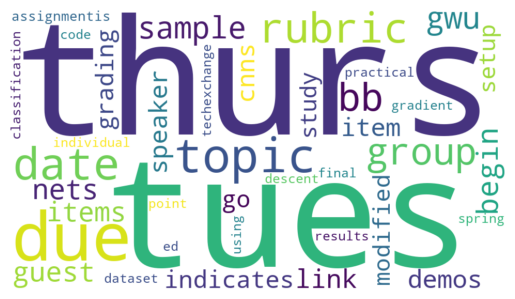

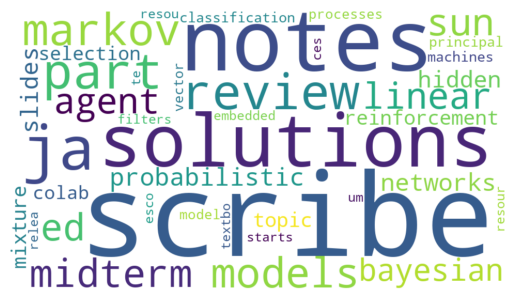

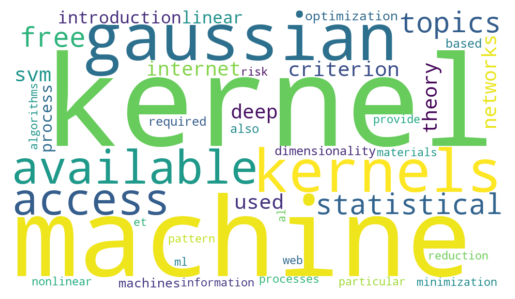

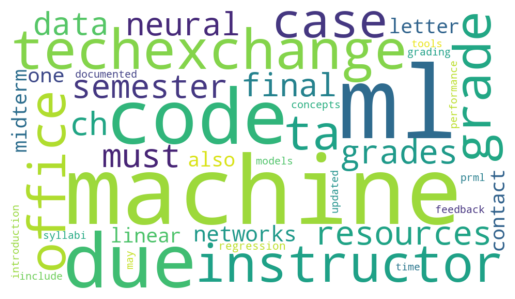

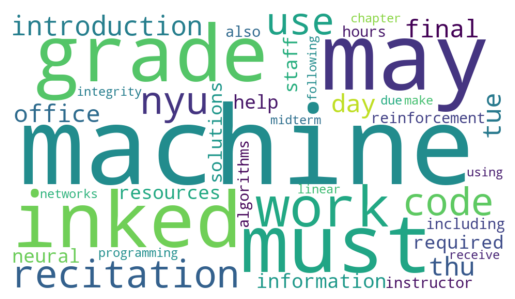

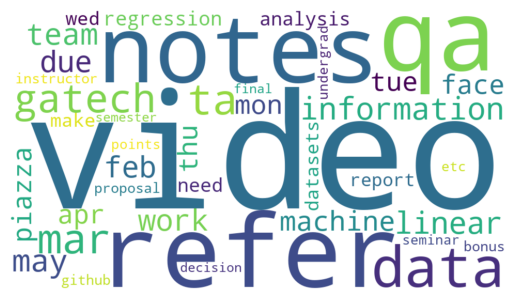

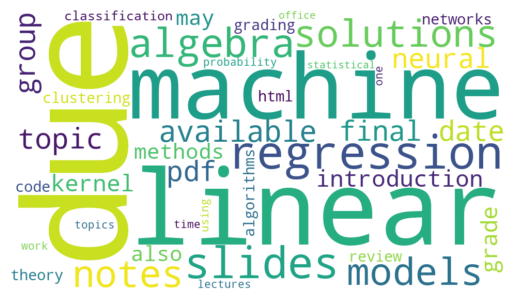

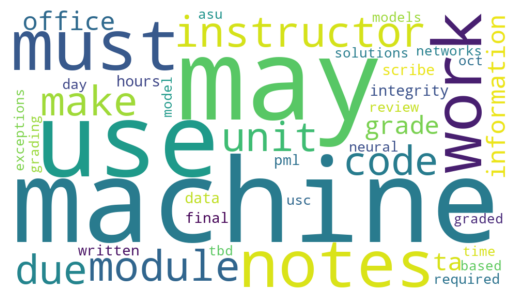

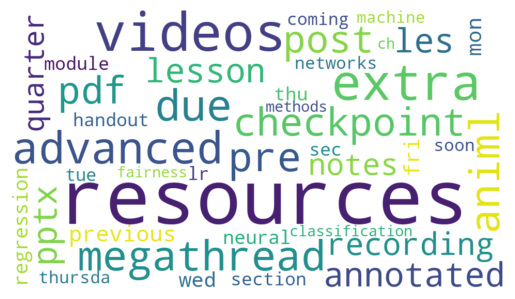

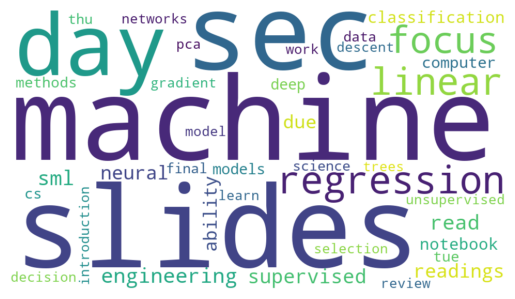

In [121]:
print("NMF Topics")
wordcloud_topics(nmf_text_model, tfidf_text.get_feature_names_out(), model_name = "NMF")
print("LDA Topics")
wordcloud_topics(lda_model, count_vectorizer.get_feature_names_out(), model_name = "LDA")